In [1]:
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
start_time = pd.datetime.now()

In [2]:
start = dt.datetime.now()

In [3]:
data = pd.read_csv('applications data.csv')

## Clean Frivolous ID Elements

In [4]:
data.apply(lambda x:x.value_counts().reset_index().iloc[0,0])

record             1000000
date              20160816
ssn              999999999
firstname         EAMSTRMT
lastname           ERJSAXA
address        123 MAIN ST
zip5                 68138
dob               19070626
homephone       9999999999
fraud_label              0
dtype: object

In [5]:
data.loc[data.ssn == 999999999,"ssn"] = -data.record
data.loc[data.address == "123 MAIN ST","address"] = -data.record
data.loc[data.dob == 19070626,"dob"] = -data.record
data.loc[data.homephone == 9999999999,"homephone"] = -data.record

In [ ]:
break

## Build Variables

### 1. Create New Entitities & Combine Entities

In [6]:
# Transform data type to string
data['ssn'] = data['ssn'].astype(str)
data['firstname'] = data['firstname'].astype(str)
data['lastname'] = data['lastname'].astype(str)
data['address'] = data['address'].astype(str)
data['zip5'] = data['zip5'].astype(str)
data['dob'] = data['dob'].astype(str)
data['homephone'] = data['homephone'].astype(str)

data['name'] = data['lastname'] + ', ' + data['firstname']
data['addr'] = data['address'] + ', ' + data['zip5']

data['name-dob'] = data['name'] + data['dob']
data['name-addr'] = data['name'] + data['addr']
data['name-homephone'] = data['name'] + data['homephone']
data['dob-addr'] = data['dob'] + data['addr']
data['dob-homephone'] = data['dob'] + data['homephone']
data['addr-homephone'] = data['addr'] + data['homephone']

data['name-dob-addr'] = data['name-dob'] + data['addr']
data['name-dob-homephone'] = data['name-dob'] + data['homephone']
data['name-addr-homephone'] = data['name-addr'] + data['homephone']
data['dob-addr-homephone'] = data['dob-addr'] + data['homephone']

data['name-dob-addr-homephone'] = data['name-dob-addr'] + data['homephone']

for i in data.columns[3:9]:
    data['ssn-{}'.format(i)] = data['ssn'] + data[i]

for i in ['name','addr','name-dob']:
    data['ssn-{}'.format(i)] = data['ssn'] + data[i]

In [7]:
attributes = list(data.columns)
for col in ['record', 'date', 'firstname', 'lastname', 'zip5', 'fraud_label']:
    attributes.remove(col)
print(len(attributes))

26


### 3. Velocity Variables

In [8]:
attributes

['ssn',
 'address',
 'dob',
 'homephone',
 'name',
 'addr',
 'name-dob',
 'name-addr',
 'name-homephone',
 'dob-addr',
 'dob-homephone',
 'addr-homephone',
 'name-dob-addr',
 'name-dob-homephone',
 'name-addr-homephone',
 'dob-addr-homephone',
 'name-dob-addr-homephone',
 'ssn-firstname',
 'ssn-lastname',
 'ssn-address',
 'ssn-zip5',
 'ssn-dob',
 'ssn-homephone',
 'ssn-name',
 'ssn-addr',
 'ssn-name-dob']

In [9]:
initialDF = data.copy()
initialDF.date = pd.to_datetime(initialDF.date,format='%Y%m%d')
finalDF = data.copy()

myData1 = initialDF.copy()
myData2 = initialDF.copy()

myData2['join_ts1'] = myData2['date']

for time_period in [0,1,3,7,14,30]:
    name_end_time = 'join_ts2_' + str(time_period)
    myData2[name_end_time] = myData2['date'] + dt.timedelta(time_period)

In [10]:
for entity in attributes:
    myData3 = myData1[['record','date',entity]]
    myData4 = myData2[['record','join_ts1','join_ts2_0','join_ts2_1','join_ts2_3','join_ts2_7'\
                           ,'join_ts2_14','join_ts2_30',entity]]
    myData4.rename(columns={'record':'record2'}, inplace=True)

    tempDF = pd.merge(myData3,myData4,left_on=[entity], right_on = [entity])

    for time_period in [0,1,3,7,14,30]:
        name_end_time = 'join_ts2_' + str(time_period)
        tempDF2 = tempDF[(tempDF['date'] <= tempDF[name_end_time])\
                            & (tempDF['record'] >= tempDF['record2'])]
        temp_name = str(entity) + '_' + str(time_period) + '_'
        groupby_count = tempDF2[['record','record2']].groupby(['record'])\
                            .size().reset_index(name = 'count').set_index('record').add_prefix(temp_name)     
        finalDF = finalDF.merge(groupby_count,\
                              left_on = 'record', right_index = True,how = 'left')

/Users/apple/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [11]:
finalDF.shape

(1000000, 188)

### 4. Days Since

In [12]:
# .dt.days --> turn x days to integer
finalDF2 = finalDF.copy()
finalDF2['date']= pd.to_datetime(finalDF2.date,format='%Y%m%d')
sincedata = finalDF2.copy()

for entity in attributes:
    sincedata1 = sincedata[['record','date',entity]]
    sincedata2 = sincedata1.copy()
    sincedata2.rename(columns={'record':'record2','date':'date2'}, inplace=True)

    match_entity2 = pd.merge(sincedata1,sincedata2,left_on = entity,right_on = entity)
    match_record2 = match_entity2[match_entity2['record'] > match_entity2['record2']]
    groupbydate = match_record2.sort_values(["record","record2"],ascending = [True,False]).groupby('record').head(1)
    # 或用GroupBy.last(self, **kwargs)[source] Compute last of group values.
    # Returns Series or DataFrame Computed last of values within each group.
    #  tmp = dff[(dff['record_x']>dff['record_y'])][['record_x','date_y']].\
    # groupby('record_x').last()['date_y'].reset_index()
    
    groupbydate = groupbydate[['record','date2']].set_index('record')
    finalDF2 = finalDF2.merge(groupbydate,left_on = 'record', right_index = True,how = 'left')
    # 直接on_record就不会重复出现record了
    
    finalDF2['date2'] = finalDF2['date2'].fillna(finalDF2['date'].min())
    finalDF2['#day_since_{}'.format(entity)] = (finalDF2['date'] - finalDF2['date2']).dt.days
    finalDF2.drop(columns=['date2'], inplace=True)    

In [13]:
finalDF2.shape

(1000000, 214)

### 5. Relative Velocity

In [14]:
i = 1
for j in [3,7,14,30]:
    for entity in attributes:
        numerator = '{}_{}_count'.format(entity,i)
        dinominator = '{}_{}_count'.format(entity,j)
        temp_name = '{}_{}_over_{}_avg'.format(entity,i,j)
        finalDF2[temp_name] = finalDF2[numerator]/(finalDF2[dinominator]/j)

In [15]:
finalDF2.shape

(1000000, 318)

### Risk Table

In [16]:
finalDF2['date'] = pd.to_datetime(finalDF2.date,format='%Y%m%d')
finalDF3 = finalDF2[finalDF2.date < '2016-11-01']

In [17]:
c=4
nmid = 20
y_avg = finalDF3['fraud_label'].mean()
finalDF3['dow'] = finalDF3['date'].dt.dayofweek
y_dow = finalDF3.groupby('dow')['fraud_label'].mean()
num_instance_dow = finalDF3.groupby('dow').size()

y_dow_smooth = y_avg + (y_dow - y_avg)/(1+np.exp(-(num_instance_dow - nmid)/c))

finalDF3['dow_risk'] = finalDF3['dow'].map(y_dow_smooth)

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Text(0.5,1,'Fraud Proportion of Each Weekday')

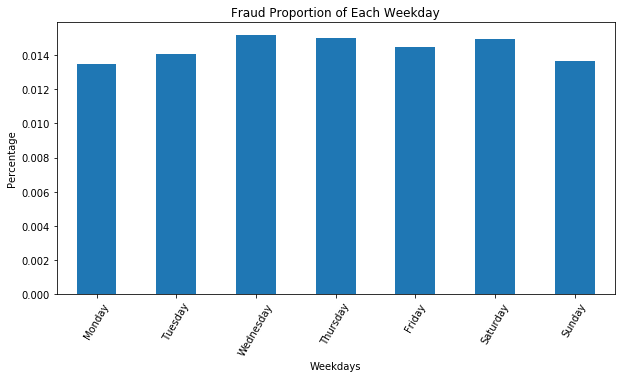

In [18]:
plt.figure(figsize=(10,5))
y_dow_smooth.plot(kind='bar')
plt.xticks(range(7),['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],rotation = 60)

plt.xlabel('Weekdays')
plt.ylabel('Percentage')
plt.title('Fraud Proportion of Each Weekday')

In [19]:
finalDF4 = finalDF3[['record','dow_risk']].set_index('record')
finalDF5 = finalDF2.merge(finalDF4,left_on = 'record',right_index = True, how = 'left')

In [20]:
finalDF5.shape

(1000000, 319)

In [21]:
final = finalDF5.iloc[:,32:]
final['fraud_label'] = finalDF2['fraud_label']

In [22]:
final.shape

(1000000, 288)

In [23]:
list(final.columns)

['ssn_0_count',
 'ssn_1_count',
 'ssn_3_count',
 'ssn_7_count',
 'ssn_14_count',
 'ssn_30_count',
 'address_0_count',
 'address_1_count',
 'address_3_count',
 'address_7_count',
 'address_14_count',
 'address_30_count',
 'dob_0_count',
 'dob_1_count',
 'dob_3_count',
 'dob_7_count',
 'dob_14_count',
 'dob_30_count',
 'homephone_0_count',
 'homephone_1_count',
 'homephone_3_count',
 'homephone_7_count',
 'homephone_14_count',
 'homephone_30_count',
 'name_0_count',
 'name_1_count',
 'name_3_count',
 'name_7_count',
 'name_14_count',
 'name_30_count',
 'addr_0_count',
 'addr_1_count',
 'addr_3_count',
 'addr_7_count',
 'addr_14_count',
 'addr_30_count',
 'name-dob_0_count',
 'name-dob_1_count',
 'name-dob_3_count',
 'name-dob_7_count',
 'name-dob_14_count',
 'name-dob_30_count',
 'name-addr_0_count',
 'name-addr_1_count',
 'name-addr_3_count',
 'name-addr_7_count',
 'name-addr_14_count',
 'name-addr_30_count',
 'name-homephone_0_count',
 'name-homephone_1_count',
 'name-homephone_3_count

In [24]:
print("Duration:", dt.datetime.now()-start)

Duration: 0:23:16.175760


In [25]:
statistics = final.describe()
statistics

,ssn_0_count,ssn_1_count,ssn_3_count,ssn_7_count,ssn_14_count,ssn_30_count,address_0_count,address_1_count,address_3_count,address_7_count,...,ssn-lastname_1_over_30_avg,ssn-address_1_over_30_avg,ssn-zip5_1_over_30_avg,ssn-dob_1_over_30_avg,ssn-homephone_1_over_30_avg,ssn-name_1_over_30_avg,ssn-addr_1_over_30_avg,ssn-name-dob_1_over_30_avg,dow_risk,fraud_label
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,833507.000000,1000000.000000
mean,1.007305,1.014924,1.020140,1.026348,1.034591,1.050823,1.011943,1.024667,1.033104,1.042545,...,29.579370,29.611788,29.610683,29.618639,29.629161,29.580967,29.612993,29.620751,0.014405,0.014393
std,0.223356,0.381210,0.423193,0.453557,0.477649,0.513331,0.283289,0.482950,0.544304,0.585750,...,2.518932,2.404854,2.408213,2.404527,2.352763,2.514285,2.401256,2.398072,0.000625,0.119104
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.764706,2.727273,2.727273,1.764706,2.727273,1.764706,2.727273,1.764706,0.013480,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,0.013674,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,0.014499,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,0.014981,0.000000
max,21.000000,34.000000,34.000000,34.000000,34.000000,34.000000,24.000000,30.000000,30.000000,30.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,0.015169,1.000000


In [26]:
statistics.to_csv('statistics.csv') 

In [27]:
final.to_csv('variables.csv') 

In [ ]:
# merge everything together
# important to cut the size of table
initialDF = data.copy()
initialDF.date = pd.to_datetime(initialDF.date,format='%Y%m%d')
final = initialDF[['record','date']]

for entity in attributes:
    myData1 = initialDF[['record','date',entity]]
    myData2 = myData1.copy()
    myData2.rename(columns={'record':'record2'}, inplace=True)
    
    # Count_past_days
    # create timeperiod
    for time_period in [0,1,3,7,14,30]:
        name_end_time = 'join_ts2_' + str(time_period)
        myData2[name_end_time] = myData2['date'] + dt.timedelta(time_period)
    
    tempDF = myData1.merge(myData2, on = entity)
    # redundent: don't hvae to write left_on=[entity], right_on = [entity]
    
    for time_period in [0,1,3,7,14,30]:
        tempDF2 = tempDF[(tempDF['date'] <= tempDF['join_ts2_{}'.format(time_period)])& (tempDF['record'] >= tempDF['record2'])]
        # here. don't have to specify entity, can do it at last at one time
        groupby_count = tempDF2[['record','record2']].groupby(['record']).size().reset_index(name = 'count_{}'.format(time_period)).set_index('record')   
        finalDF = myData1.merge(groupby_count,left_on = 'record', right_index = True,how = 'left')
        # here only merge table with record/date, not the whole table!!!! 
        # now finaldf: record,date,counts of one attribute in past x days
        
    # day since
    # here, copy table, rename, merge etc are eliminated 
    # take only record 1 and 2 in match_record2 to min the size to groupby
    match_record2 = tempDF[tempDF['record'] > tempDF['record2']][['record','record2']]
    groupbydate = match_record2.sort_values(["record","record2"],ascending = [True,False]).groupby('record').head(1)
    # 或用groupby().last()
    groupbydate = groupbydate[['record','date2']].set_index('record')
    finalDF = finalDF.merge(groupbydate,left_on = 'record', right_index = True,how = 'left')
    # 直接on_record就不会重复出现record了
    finalDF['date2'] = finalDF['date2'].fillna(finalDF['date'].min())
    finalDF['#day_since_{}'.format(entity)] = (finalDF['date'] - finalDF['date2']).dt.days
    finalDF.drop(columns=[['date2']], inplace=True)  
    
    # relative
    i = 1
    for j in [3,7,14,30]:
        numerator = '{}_count'.format(i)
        dinominator = '{}_count'.format(j)
        temp_name = '{}_over_{}_avg'.format(i,j)
        finalDF[temp_name] = finalDF[numerator]/(finalDF[dinominator]/j)
    
    finalDF.drop(columns=['date',entity], inplace=True)
    finalDF = finalDF.set_index('record')
    # add prefix over here!!!!!
    finalDF = finalDF.add_prefix('{}_'.format(entity))
    final = final.merge(finalDF, left_on='record', right_index=True) 